# Long Book

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Import dendrogram, linkage to create dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

# Import pyfolio to backtest the strategy
import pyfolio as pf

# Import yfinance library
import yfinance as yf

## Import data

In [2]:
# Import data from Excel file
data = pd.read_excel('/Users/lucadonghi/Desktop/Short list.xlsx', sheet_name='Dataset 2018')
data.head()

,ISIN,Name,Weight,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,D/C TTM,Mkt Cap (mln USD)
0,US02079K3059,Alphabet Inc A,0.60796,Communication Services,56.48,19.77,0.1726,2.2931,723558.708460
1,NL0009805522,Yandex NV,0.53159,Communication Services,71.88,8.87,0.2625,17.7733,8881.284080
2,US64110W1027,NetEase Inc ADR,0.51224,Communication Services,53.43,40.96,0.1024,NaN,30118.118480
3,US68555P1003,ORBCOMM Inc,0.50763,Communication Services,46.90,30.06,-0.0247,48.7579,634.693431
4,US30303M1027,Facebook Inc A,0.46326,Communication Services,83.25,47.97,0.2702,NaN,374130.860000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ISIN               371 non-null    object 
 1   Name               371 non-null    object 
 2   Weight             371 non-null    float64
 3   GICS Sector        335 non-null    object 
 4   Gross Margin       301 non-null    float64
 5   Rev. Gwth.         305 non-null    float64
 6   ROIC               314 non-null    float64
 7   D/C TTM            258 non-null    float64
 8   Mkt Cap (mln USD)  286 non-null    float64
dtypes: float64(6), object(3)
memory usage: 26.2+ KB


In [4]:
# Covert data type to float
data[['Gross Margin', 'Rev. Gwth.', 'ROIC', 'D/C TTM']] = data[['Gross Margin', 'Rev. Gwth.', 'ROIC', 'D/C TTM']].astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ISIN               371 non-null    object 
 1   Name               371 non-null    object 
 2   Weight             371 non-null    float64
 3   GICS Sector        335 non-null    object 
 4   Gross Margin       301 non-null    float64
 5   Rev. Gwth.         305 non-null    float64
 6   ROIC               314 non-null    float64
 7   D/C TTM            258 non-null    float64
 8   Mkt Cap (mln USD)  286 non-null    float64
dtypes: float64(6), object(3)
memory usage: 26.2+ KB


In [5]:
# Drop useless columns
data_new = data.drop(['Weight', 'D/C TTM'], axis=1)
data_new.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD)
0,US02079K3059,Alphabet Inc A,Communication Services,56.48,19.77,0.1726,723558.708460
1,NL0009805522,Yandex NV,Communication Services,71.88,8.87,0.2625,8881.284080
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.118480
3,US68555P1003,ORBCOMM Inc,Communication Services,46.90,30.06,-0.0247,634.693431
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.860000


In [6]:
# Drop rows where "GICS Sector" column has NaN values
df_cleaned = data_new.dropna(subset=['GICS Sector'])
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 370
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ISIN               335 non-null    object 
 1   Name               335 non-null    object 
 2   GICS Sector        335 non-null    object 
 3   Gross Margin       301 non-null    float64
 4   Rev. Gwth.         305 non-null    float64
 5   ROIC               314 non-null    float64
 6   Mkt Cap (mln USD)  286 non-null    float64
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


## Screening stocks

In [7]:
# Define a function to apply Min-Max scaling within each sector
# Define a function to apply Min-Max scaling within each sector and treat NaN as 0
def min_max_scaling(group):
    group = group.fillna(0)  # Fill NaN values with 0
    group['Gross Margin MinMax'] = (group['Gross Margin'] - group['Gross Margin'].min()) / (group['Gross Margin'].max() - group['Gross Margin'].min())
    group['Rev. Gwth. MinMax'] = (group['Rev. Gwth.'] - group['Rev. Gwth.'].min()) / (group['Rev. Gwth.'].max() - group['Rev. Gwth.'].min())
    group['ROIC MinMax'] = (group['ROIC'] - group['ROIC'].min()) / (group['ROIC'].max() - group['ROIC'].min())
    return group

# Apply the scaling function within each sector group
df_cleaned = df_cleaned.groupby('GICS Sector').apply(min_max_scaling)

In [8]:
df_cleaned.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD),Gross Margin MinMax,Rev. Gwth. MinMax,ROIC MinMax
0,US02079K3059,Alphabet Inc A,Communication Services,56.48,19.77,0.1726,723558.708460,0.601747,0.436675,0.812321
1,NL0009805522,Yandex NV,Communication Services,71.88,8.87,0.2625,8881.284080,0.765821,0.265399,0.924207
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.118480,0.569252,0.769642,0.724953
3,US68555P1003,ORBCOMM Inc,Communication Services,46.90,30.06,-0.0247,634.693431,0.499680,0.598366,0.566770
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.860000,0.886959,0.879793,0.933790


In [9]:
# Calculate Score for each stock 
df_cleaned['Score'] = df_cleaned['Gross Margin MinMax'] + df_cleaned['Rev. Gwth. MinMax'] + df_cleaned['ROIC MinMax']
df_cleaned.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD),Gross Margin MinMax,Rev. Gwth. MinMax,ROIC MinMax,Score
0,US02079K3059,Alphabet Inc A,Communication Services,56.48,19.77,0.1726,723558.708460,0.601747,0.436675,0.812321,1.850743
1,NL0009805522,Yandex NV,Communication Services,71.88,8.87,0.2625,8881.284080,0.765821,0.265399,0.924207,1.955427
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.118480,0.569252,0.769642,0.724953,2.063847
3,US68555P1003,ORBCOMM Inc,Communication Services,46.90,30.06,-0.0247,634.693431,0.499680,0.598366,0.566770,1.664817
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.860000,0.886959,0.879793,0.933790,2.700542


In [10]:
# Define a function to assign quartiles within each sector based on the "Score"
def assign_quartiles(group):
    group['Quartile'] = pd.qcut(group['Score'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    return group

# Apply the quartile assignment function within each sector group
df_cleaned = df_cleaned.groupby('GICS Sector').apply(assign_quartiles)

In [11]:
df_cleaned.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD),Gross Margin MinMax,Rev. Gwth. MinMax,ROIC MinMax,Score,Quartile
0,US02079K3059,Alphabet Inc A,Communication Services,56.48,19.77,0.1726,723558.708460,0.601747,0.436675,0.812321,1.850743,Q3
1,NL0009805522,Yandex NV,Communication Services,71.88,8.87,0.2625,8881.284080,0.765821,0.265399,0.924207,1.955427,Q3
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.118480,0.569252,0.769642,0.724953,2.063847,Q4
3,US68555P1003,ORBCOMM Inc,Communication Services,46.90,30.06,-0.0247,634.693431,0.499680,0.598366,0.566770,1.664817,Q2
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.860000,0.886959,0.879793,0.933790,2.700542,Q4


In [12]:
# Keep only stocks in top quartile
short_list = df_cleaned[df_cleaned['Quartile'] == 'Q4']
short_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 2 to 368
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ISIN                 85 non-null     object  
 1   Name                 85 non-null     object  
 2   GICS Sector          85 non-null     object  
 3   Gross Margin         85 non-null     float64 
 4   Rev. Gwth.           85 non-null     float64 
 5   ROIC                 85 non-null     float64 
 6   Mkt Cap (mln USD)    85 non-null     float64 
 7   Gross Margin MinMax  85 non-null     float64 
 8   Rev. Gwth. MinMax    85 non-null     float64 
 9   ROIC MinMax          85 non-null     float64 
 10  Score                85 non-null     float64 
 11  Quartile             85 non-null     category
dtypes: category(1), float64(8), object(3)
memory usage: 8.3+ KB


In [13]:
short_list.head()

,ISIN,Name,GICS Sector,Gross Margin,Rev. Gwth.,ROIC,Mkt Cap (mln USD),Gross Margin MinMax,Rev. Gwth. MinMax,ROIC MinMax,Score,Quartile
2,US64110W1027,NetEase Inc ADR,Communication Services,53.43,40.96,0.1024,30118.11848,0.569252,0.769642,0.724953,2.063847,Q4
4,US30303M1027,Facebook Inc A,Communication Services,83.25,47.97,0.2702,374130.86000,0.886959,0.879793,0.933790,2.700542,Q4
11,US9485961018,Weibo Corp ADR Class A,Communication Services,83.84,55.62,0.2276,13137.25810,0.893245,1.000000,0.880772,2.774017,Q4
13,US57665R1068,Match Group Inc,Communication Services,76.30,16.59,0.3234,0.00000,0.812913,0.386706,1.000000,2.199619,Q4
14,US90184L1026,Twitter Inc,Communication Services,68.28,35.55,0.1492,21964.74618,0.727466,0.684632,0.783199,2.195297,Q4


In [14]:
# Filter stocks by removing those with a market cap smaller than USD 2 bln
short_list_new = short_list[short_list['Mkt Cap (mln USD)'] >= 2000]

In [15]:
short_list_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 2 to 368
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ISIN                 60 non-null     object  
 1   Name                 60 non-null     object  
 2   GICS Sector          60 non-null     object  
 3   Gross Margin         60 non-null     float64 
 4   Rev. Gwth.           60 non-null     float64 
 5   ROIC                 60 non-null     float64 
 6   Mkt Cap (mln USD)    60 non-null     float64 
 7   Gross Margin MinMax  60 non-null     float64 
 8   Rev. Gwth. MinMax    60 non-null     float64 
 9   ROIC MinMax          60 non-null     float64 
 10  Score                60 non-null     float64 
 11  Quartile             60 non-null     category
dtypes: category(1), float64(8), object(3)
memory usage: 5.9+ KB


In [16]:
# Count the number of stocks per GICS Sector
sector_counts = short_list_new['GICS Sector'].value_counts()

print(sector_counts)

Information Technology    17
Health Care               13
Industrials               10
Consumer Discretionary     6
Communication Services     5
Financials                 4
Materials                  2
Utilities                  2
Energy                     1
Name: GICS Sector, dtype: int64


## Import short-listed stock prices

In [17]:
prices = pd.read_excel('/Users/lucadonghi/Desktop/Short list.xlsx', sheet_name='Prices', header=1, index_col=0)
prices.head()

,NetEase Inc ADR,Facebook Inc A,Weibo Corp ADR Class A,Twitter Inc,Yelp Inc Class A,Tesla Inc,Garmin Ltd,ADT Inc,iRobot Corp,MercadoLibre Inc,...,Palo Alto Networks Inc,Analog Devices Inc,Check Point Software Technologies Ltd,F5 Networks Inc,Texas Instruments Inc,Fortinet Inc,Ingevity Corp,Ball Corp,NextEra Energy Inc,Algonquin Power & Utilities Corp
2018-12-31,47.074,131.09,58.43,28.6599,34.99,22.18667,63.32,6.01,83.74,292.85,...,62.78333,85.83,102.65,162.03,94.50,14.086,83.69,45.98,43.4550,10.052716
2019-01-01,47.074,131.09,58.43,28.6599,34.99,22.18667,63.32,6.01,83.74,292.85,...,62.78333,85.83,102.65,162.03,94.50,14.086,83.69,45.98,43.4550,10.052716
2019-01-02,45.948,135.68,58.94,28.8529,34.57,20.67467,62.52,6.41,79.24,298.01,...,61.07000,85.92,103.50,161.18,94.45,13.936,84.02,44.67,42.4575,9.944142
2019-01-03,44.180,131.74,55.97,28.2527,33.64,20.02400,61.39,6.32,78.28,296.59,...,59.90000,80.73,102.35,154.31,88.88,13.514,79.69,44.26,42.3525,10.019981
2019-01-04,45.950,137.95,61.23,29.8000,34.56,21.17933,63.72,6.67,83.32,315.33,...,61.46333,82.69,105.35,159.79,92.90,13.382,83.99,45.59,43.1325,10.118736


In [18]:
rets = prices.pct_change().fillna(0)
rets.head()

,NetEase Inc ADR,Facebook Inc A,Weibo Corp ADR Class A,Twitter Inc,Yelp Inc Class A,Tesla Inc,Garmin Ltd,ADT Inc,iRobot Corp,MercadoLibre Inc,...,Palo Alto Networks Inc,Analog Devices Inc,Check Point Software Technologies Ltd,F5 Networks Inc,Texas Instruments Inc,Fortinet Inc,Ingevity Corp,Ball Corp,NextEra Energy Inc,Algonquin Power & Utilities Corp
2018-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2019-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.221245e-15
2019-01-02,-0.023920,0.035014,0.008728,0.006734,-0.012003,-0.068149,-0.012634,0.066556,-0.053738,0.017620,...,-0.027290,0.001049,0.008281,-0.005246,-0.000529,-0.010649,0.003943,-0.028491,-0.022955,-1.080047e-02
2019-01-03,-0.038478,-0.029039,-0.050390,-0.020802,-0.026902,-0.031472,-0.018074,-0.014041,-0.012115,-0.004765,...,-0.019158,-0.060405,-0.011111,-0.042623,-0.058973,-0.030281,-0.051535,-0.009178,-0.002473,7.626446e-03
2019-01-04,0.040063,0.047138,0.093979,0.054766,0.027348,0.057697,0.037954,0.055380,0.064384,0.063185,...,0.026099,0.024278,0.029311,0.035513,0.045230,-0.009768,0.053959,0.030050,0.018417,9.855878e-03


In [19]:
rets.tail()

,NetEase Inc ADR,Facebook Inc A,Weibo Corp ADR Class A,Twitter Inc,Yelp Inc Class A,Tesla Inc,Garmin Ltd,ADT Inc,iRobot Corp,MercadoLibre Inc,...,Palo Alto Networks Inc,Analog Devices Inc,Check Point Software Technologies Ltd,F5 Networks Inc,Texas Instruments Inc,Fortinet Inc,Ingevity Corp,Ball Corp,NextEra Energy Inc,Algonquin Power & Utilities Corp
2024-08-26,0.004995,-0.013030,-0.009009,0.0,-0.005721,-0.032271,-0.001279,-0.010681,-0.013183,0.002195,...,-0.010349,-0.012172,-0.004204,0.002010,-0.007766,0.006022,0.006764,-0.003408,0.012302,0.009205
2024-08-27,0.012608,-0.003876,-0.015584,0.0,-0.001151,-0.018761,0.006239,0.005398,-0.041985,0.015718,...,0.008844,0.027614,-0.006913,0.001504,0.011717,0.010508,-0.002584,-0.004352,-0.012773,-0.012562
2024-08-28,-0.037831,-0.004469,-0.031662,0.0,-0.009505,-0.016538,-0.003155,-0.012081,-0.021248,-0.020155,...,0.000714,-0.020143,0.007279,-0.004106,-0.014002,-0.004739,0.002850,-0.008898,-0.002512,-0.009796
2024-08-29,0.001991,0.002786,0.016349,0.0,0.015121,0.002576,0.003165,0.000000,0.008820,0.010335,...,0.022172,0.016375,0.010761,0.016341,0.016126,0.008729,0.019633,-0.017326,0.007808,0.012520
2024-08-30,-0.001118,0.005963,0.002681,0.0,0.000573,0.037958,0.014614,-0.009511,-0.015467,0.022755,...,0.012590,0.017108,0.004645,0.004997,0.015396,0.005769,0.001520,0.022760,0.005998,0.010915


## Find weights by applying HRP

In [20]:
stock_returns_hrp = prices.resample("1M", label='left').last().pct_change().dropna()

In [21]:
stock_returns_hrp.head()

,NetEase Inc ADR,Facebook Inc A,Weibo Corp ADR Class A,Twitter Inc,Yelp Inc Class A,Tesla Inc,Garmin Ltd,ADT Inc,iRobot Corp,MercadoLibre Inc,...,Palo Alto Networks Inc,Analog Devices Inc,Check Point Software Technologies Ltd,F5 Networks Inc,Texas Instruments Inc,Fortinet Inc,Ingevity Corp,Ball Corp,NextEra Energy Inc,Algonquin Power & Utilities Corp
2018-12-31,0.070357,0.271569,0.038165,0.168357,0.040869,-0.077464,0.092546,0.201331,0.072247,0.242957,...,0.140536,0.151812,0.090307,-0.006665,0.065397,0.087179,0.124029,0.137016,0.029686,0.099057
2019-01-31,-0.113960,-0.031436,0.191065,-0.086158,0.023064,0.041886,0.213790,0.108033,0.392805,0.260412,...,0.146402,0.081934,0.092745,0.044672,0.050656,0.133473,0.224833,0.047819,0.048832,0.003376
2019-02-28,0.081668,0.032456,-0.142007,0.078758,-0.074074,-0.125109,0.028343,-0.201250,-0.058932,0.106672,...,-0.013765,-0.015800,0.034260,-0.066671,0.002742,-0.032492,-0.083406,0.056225,0.029832,0.014850
2019-03-31,0.178422,0.160238,0.105017,0.211754,0.161159,-0.147109,-0.007064,0.031299,-0.120231,-0.046462,...,0.024498,0.104208,-0.045300,-0.000191,0.110870,0.112540,0.089007,0.035949,0.005794,0.010303
2019-04-30,-0.126243,-0.082368,-0.393869,-0.084375,-0.232901,-0.224266,-0.108001,-0.112291,-0.158683,0.178419,...,-0.195676,-0.168789,-0.086784,-0.158190,-0.114742,-0.224149,-0.237458,0.024191,0.019389,0.026281


In [22]:
# Split the stock_returns dataframe
returns_till_2020 = stock_returns_hrp[:'2020']

In [23]:
# Take a transpose of returns_till_2020
returns_till_2020_transpose = stock_returns_hrp[:'2020'].T

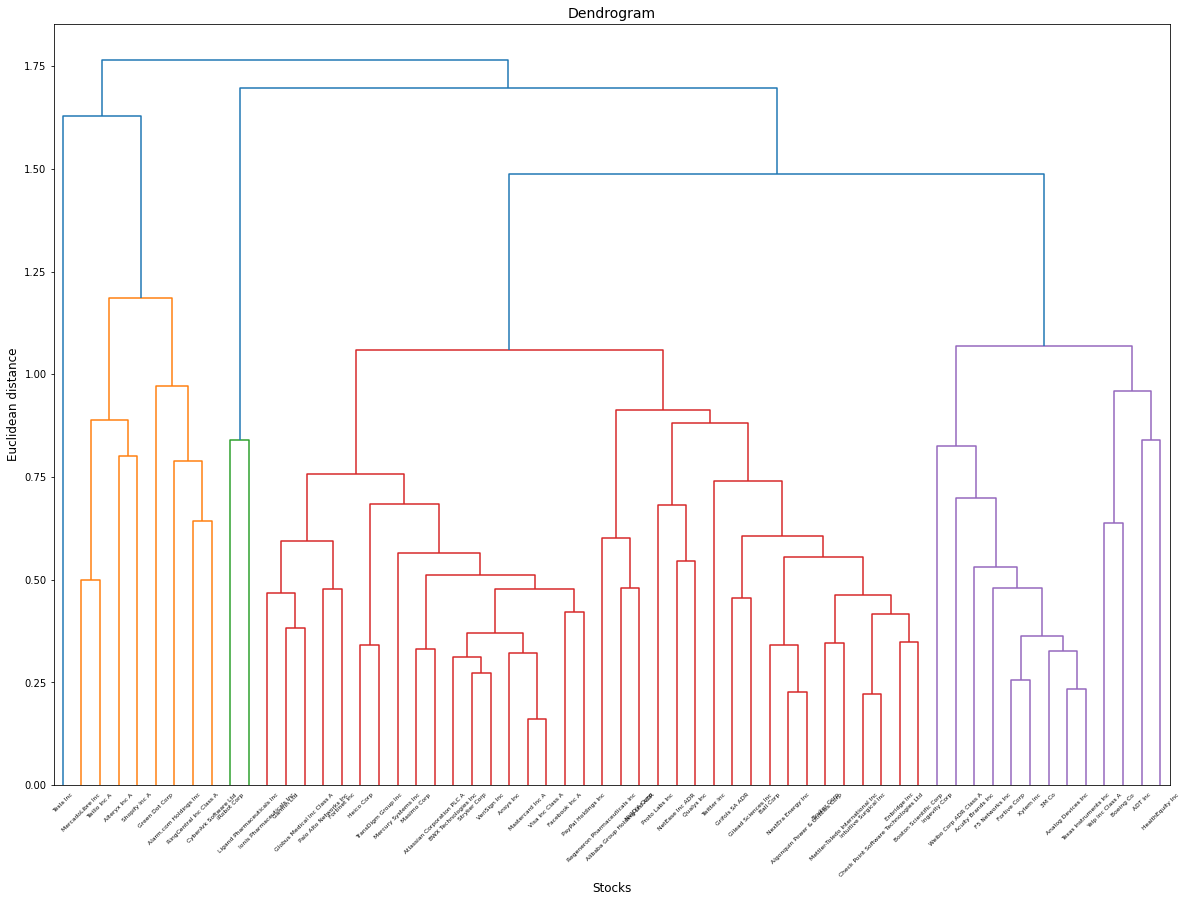

In [24]:
# Define the size of the graph
plt.figure(figsize=(20, 14))

# Title of the chart
plt.title('Dendrogram', fontsize=14)

# Create linkage matrix
linkage_matrix = linkage(returns_till_2020_transpose, method='ward')

# Create dendrogram
dendrogram(linkage_matrix, labels=returns_till_2020_transpose.index)

# Define labels
plt.xlabel("Stocks", fontsize=12)
plt.ylabel('Euclidean distance', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [25]:
# Step 1: Define an agglomerative clustering model
model = AgglomerativeClustering(n_clusters=2,
                                  affinity='euclidean', linkage='ward')

# Step 2: Call fit_predict_method on scaled training data. This labels the stocks as 0 and 1
clusters = model.fit_predict(returns_till_2020_transpose)

# Step 3: Get tickers of cluster_0 and cluster_1 using labels 0 and 1
cluster_0 = returns_till_2020_transpose.loc[clusters == 0, :].index

cluster_1 = returns_till_2020_transpose.loc[clusters == 1, :].index

# Cluster_0
print(f'The stocks in cluster_0 are: {cluster_0.to_list()}')

# Cluster_1
print(f'The stocks in cluster_1 are: {cluster_1.to_list()}')

The stocks in cluster_0 are: ['NetEase Inc ADR', 'Facebook Inc A', 'Weibo Corp ADR Class A', 'Twitter Inc', 'Yelp Inc Class A', 'Garmin Ltd', 'ADT Inc', 'iRobot Corp', 'Alibaba Group Holding Ltd ADR', 'Enbridge Inc', 'PayPal Holdings Inc', 'Mastercard Inc A', 'Visa Inc Class A', 'Bruker Corp', 'Masimo Corp', 'Boston Scientific Corp', 'Intuitive Surgical Inc', 'Stryker Corp', 'Globus Medical Inc Class A', 'Mettler-Toledo International Inc', 'Grifols SA ADR', 'Gilead Sciences Inc', 'Regeneron Pharmaceuticals Inc', 'Ionis Pharmaceuticals Inc', 'Ligand Pharmaceuticals Inc', 'HealthEquity Inc', 'Proto Labs Inc', 'Boeing Co', 'Fortive Corp', '3M Co', 'Acuity Brands Inc', 'Heico Corp', 'TransDigm Group Inc', 'Mercury Systems Inc', 'Xylem Inc', 'BWX Technologies Inc', 'Atlassian Corporation PLC A', 'Ansys Inc', 'NVIDIA Corp', 'VeriSign Inc', 'Qualys Inc', 'Palo Alto Networks Inc', 'Analog Devices Inc', 'Check Point Software Technologies Ltd', 'F5 Networks Inc', 'Texas Instruments Inc', 'Fortin

In [26]:
# Function to calculate cluster volatility
def calculate_cluster_volatility(returns_data, tickers):

    # Calculating the standard deviation of stocks returns in the tickers list
    volatility = returns_data[tickers].std()

    # Calculate the weights of stocks using inverse volatility method
    weights = (1/volatility)/np.sum(1/volatility)

    # Multiply the returns data with weights calculated to get cluster returns
    cluster_returns = returns_data[tickers].dot(weights)

    # Calculate the volatility of cluster using standard deviation of cluster returns
    cluster_volatility = cluster_returns.std()

    return cluster_volatility

In [27]:
def hrp_weights(tickers, dataset, returns_data,weights_hrp_initital):

    if len(tickers) > 1:
        
        input_df = dataset.loc[tickers]

        # Hierarchical Clustering using Agglomerative Clustering

        # Step 1: Define an agglomerative clustering model
        model = AgglomerativeClustering(
            n_clusters=2, affinity='euclidean', linkage='ward')
        
        # Step 2: Call fit_predict_method on dataset
        clusters = model.fit_predict(input_df)

        # Step 3: Get tickers of cluster_0 and cluster_1
        cluster_0 = input_df.loc[clusters == 0, :].index
        
        cluster_1 = input_df.loc[clusters == 1, :].index
        
        # Step-4: Calculate the volatility of cluster_0 and cluster_1 
        cluster_0_volatility  = calculate_cluster_volatility(returns_data[cluster_0], cluster_0)
        
        cluster_1_volatility  = calculate_cluster_volatility(returns_data[cluster_1], cluster_1)

        # Step-5: Calculate the weights of cluster_0 and cluster_1
        weight_cluster_0 = (1/cluster_0_volatility)/((1/cluster_0_volatility)+(1/cluster_1_volatility))
        
        weight_cluster_1 = (1/cluster_1_volatility)/((1/cluster_0_volatility)+(1/cluster_1_volatility))

        # Multiply the weights of tickers in 'weights_hrp_initial' dataframe with respective weights of cluster_0 and cluster_1
        weights_hrp_initital.loc[cluster_0, 'HRP'] *= weight_cluster_0
        
        weights_hrp_initital.loc[cluster_1, 'HRP'] *= weight_cluster_1

        # Run the clustering algorithm on the new clusters i.e. cluster_0 and cluster_1
        hrp_weights(cluster_0, dataset, returns_data, weights_hrp_initital)
        
        hrp_weights(cluster_1, dataset, returns_data, weights_hrp_initital)
        
        # Create weights_hrp dataframe
        weights_hrp = weights_hrp_initital

        # output weights_hrp
        return weights_hrp

In [28]:
# tickers
tickers = returns_till_2020_transpose.index.to_list()
weights_hrp_initital = pd.DataFrame(
        [1]*len(tickers), index=tickers, columns=['HRP'])
weights_hrp = hrp_weights(tickers,returns_till_2020_transpose, returns_till_2020, weights_hrp_initital)
round(weights_hrp.sort_values(by='HRP', ascending=False).head(10), 2)

,HRP
Tesla Inc,0.10
iRobot Corp,0.08
Ligand Pharmaceuticals Inc,0.07
Green Dot Corp,0.05
Ingevity Corp,0.04
Alarm.com Holdings Inc,0.03
Shopify Inc A,0.03
Weibo Corp ADR Class A,0.03
Regeneron Pharmaceuticals Inc,0.03
MercadoLibre Inc,0.03


In [29]:
weights = weights_hrp.sort_values(by='HRP', ascending=False)
weights.head(10)

,HRP
Tesla Inc,0.101374
iRobot Corp,0.079589
Ligand Pharmaceuticals Inc,0.072350
Green Dot Corp,0.050806
Ingevity Corp,0.035281
Alarm.com Holdings Inc,0.033578
Shopify Inc A,0.030983
Weibo Corp ADR Class A,0.030738
Regeneron Pharmaceuticals Inc,0.030500
MercadoLibre Inc,0.028272


In [30]:
weights.to_excel("long_book.xlsx")

## Redistribute weights

In [31]:
def sanity_check_and_allocation(data, weight_limit=0.10):
    """Check if weight redistribution is possible"""
    # Get the total number of stocks available
    num_stocks = len(data.index)

    # Calculate the minimum number of stocks needed for the given weight_limit
    num_stocks_needed = np.ceil(1 / weight_limit)    
   
    # Proceed if sufficient stocks are available
    if (num_stocks < num_stocks_needed):
        print(f"Weight redistribution is not possible. Add {num_stocks_needed - num_stocks} more stocks or reduce the weight limit to {round(1 / num_stocks, 2)}.")
    else:
        return redistribute_weights(data, weight_limit)

def redistribute_weights(data, weight_limit):
    """
    Code to redistribute weights between stocks.
    """
    # Sort the dataframe to get the stock with maximum weight
    data = data.sort_values(by=data.columns.to_list(), ascending=False)

    if data.iloc[0][0] <= weight_limit:
        data.rename(columns={"Original": "New"}, inplace=True)
        return data

    # If stock with maximum weights is greater than the weight_limit,
    # reassign weights
    if data.iloc[0][0] > weight_limit:
        # Calculate excess weight
        excess_weight = data.iloc[0][0] - weight_limit

        # Assign weight_limit to stock with excess weight
        data.iloc[0][0] = weight_limit

        # Calculate ratio of distribution of excess weight
        ratio = (data.iloc[1:] / data.iloc[1:].sum())

        # Distribute excess weight
        excess_weight_distribution = data.iloc[1:] + (ratio * excess_weight)

        # Update the weights
        data.iloc[1:, :] = excess_weight_distribution                
        return pd.concat([pd.DataFrame(data.iloc[0]).T,redistribute_weights(data.iloc[1:], weight_limit)])         
    return data

In [32]:
# Calculating the new weights after redistribution
new_weights = sanity_check_and_allocation(weights, weight_limit=0.03)

In [33]:
new_weights.mul(100).head(10)

,HRP
Tesla Inc,3.0
iRobot Corp,3.0
Ligand Pharmaceuticals Inc,3.0
Green Dot Corp,3.0
Ingevity Corp,3.0
Alarm.com Holdings Inc,3.0
Shopify Inc A,3.0
Weibo Corp ADR Class A,3.0
Regeneron Pharmaceuticals Inc,3.0
MercadoLibre Inc,3.0


In [34]:
new_weights.mul(100).tail(10)

,HRP
Check Point Software Technologies Ltd,0.291009
Boston Scientific Corp,0.278386
Ansys Inc,0.270546
Enbridge Inc,0.260147
Intuitive Surgical Inc,0.236280
BWX Technologies Inc,0.233888
VeriSign Inc,0.164671
Stryker Corp,0.151574
Visa Inc Class A,0.139656
Mastercard Inc A,0.116703


## Backtesting long-only strategy

In [35]:
# Take returns from January 2020 for backtest 
rets_bt = rets.loc['2020-01-02':]

# Calculate strategy daily returns
hrp_returns = rets_bt @ new_weights['HRP']

# HRP Cumulative returns
hrp_cum_rets = (1 + hrp_returns).cumprod()

In [36]:
# Define the ticker symbol
ticker_symbol = 'KOMP'

# Define the start and end dates
start_date = '2020-01-02'
end_date = '2024-08-31'

# Fetch the historical daily data
komp_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')['Adj Close']

# Reindex 'komp_data' to match the index of 'rets_bt'
komp_data_aligned = komp_data.reindex(rets_bt.index)

# Display the first few rows
print(komp_data_aligned.head())

[*********************100%***********************]  1 of 1 completed
2020-01-02    34.611073
2020-01-03    34.516476
2020-01-06    34.592152
2020-01-07    34.611073
2020-01-08    34.847546
Name: Adj Close, dtype: float64


In [37]:
# Calculate benchmark returns
komp_rets = komp_data_aligned.pct_change().fillna(0)
komp_rets.head()

2020-01-02    0.000000
2020-01-03   -0.002733
2020-01-06    0.002192
2020-01-07    0.000547
2020-01-08    0.006832
Name: Adj Close, dtype: float64

In [38]:
# Fetch style indices for pyfolio style analysis

# Value
# Momentum
# Size
# Low Vol

In [39]:
# Calculate style indices returns


Start date,2020-01-02
End date,2024-08-30
Total months,57
,Backtest
Annual return,11.2%
Cumulative returns,66.9%
Annual volatility,25.7%
Sharpe ratio,0.54
Calmar ratio,0.31
Stability,0.10
Max drawdown,-35.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.66,2021-11-12,2022-10-14,NaT,NaN
1,35.58,2020-02-19,2020-03-18,2020-05-26,70
2,14.05,2021-02-09,2021-03-08,2021-04-26,55
3,10.75,2020-09-02,2020-09-24,2020-10-09,28
4,10.31,2021-04-26,2021-05-13,2021-06-24,44


Stress Events,mean,min,max
New Normal,0.06%,-11.65%,10.56%


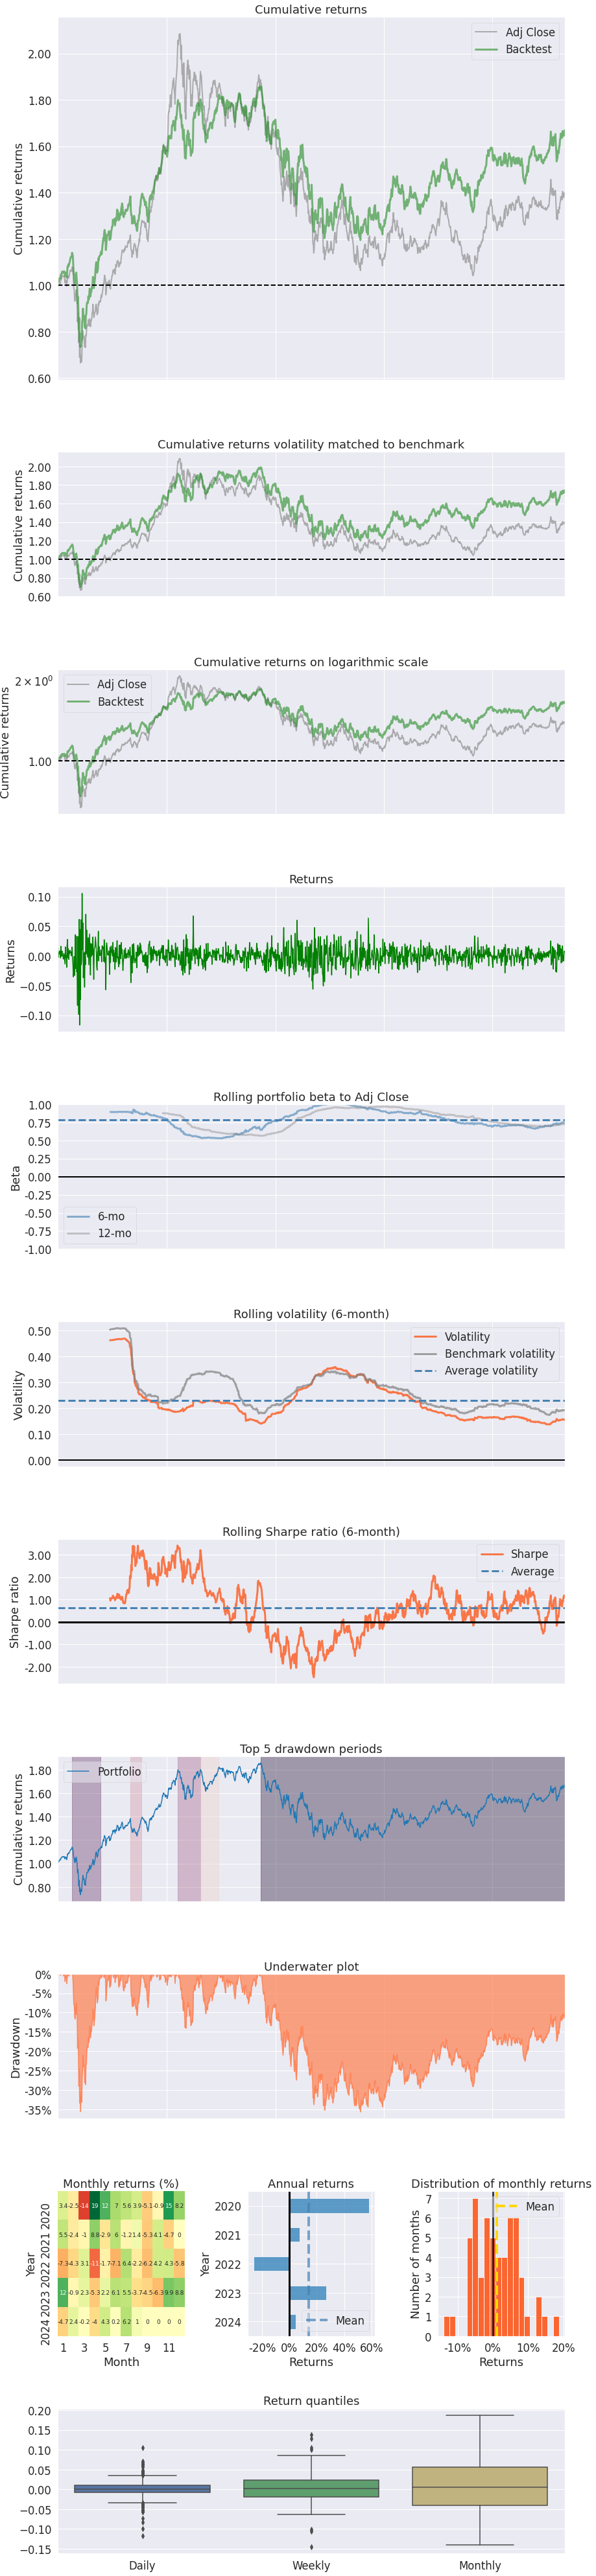

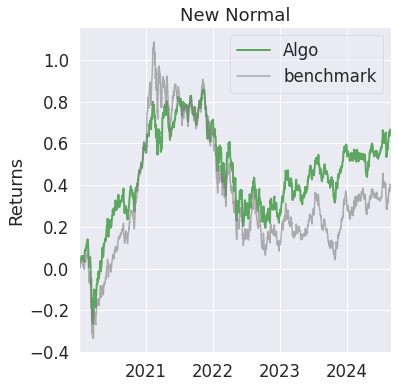

In [40]:
pf.create_full_tear_sheet(hrp_returns, 
                          benchmark_rets=komp_rets)

# Short Book

## Import libraries

In [70]:
from datetime import datetime

# Calculates swing highs and lows
from scipy.signal import *
from scipy.signal import argrelextrema

# Appends new file paths to import modules
import sys
sys.path.append("/Users/lucadonghi/Desktop/QuantraShortSellingResources")

# All functions library
from data_modules import short_selling
from data_modules import short_selling_modified

# Imports charting libraries
%matplotlib inline

# Construct a list of permutations
import itertools as it

## Import data

In [42]:
# Import tickers of S&P 500 first top 50 stocks (excl. stocks in long book)
tickers = pd.read_excel('/Users/lucadonghi/Desktop/Ticker_list.xlsx')

In [43]:
# Store tickers in a list
tickers_list = tickers['Ticker'].to_list()

In [44]:
# Fetch the historical OHLC data
short_book_px = yf.download(tickers_list, start=start_date, end=end_date, interval='1d', group_by='ticker')

# Reindex 'short_book_px' to match the index of 'rets_bt'
short_book_px_aligned = short_book_px.reindex(rets_bt.index)

# Display the first few rows
print(short_book_px_aligned.head())

[*********************100%***********************]  100 of 100 completed
                  ISRG                                                  \
                  Open        High         Low       Close   Adj Close   
2020-01-02  198.566666  199.276672  196.929993  199.086670  199.086670   
2020-01-03  196.059998  198.193329  194.053329  197.779999  197.779999   
2020-01-06  196.666672  199.206665  195.983337  198.586670  198.586670   
2020-01-07  196.649994  196.649994  191.246674  194.266663  194.266663   
2020-01-08  193.846664  195.123337  192.196671  193.926666  193.926666   

                            CSCO                                   ...  \
               Volume       Open       High        Low      Close  ...   
2020-01-02  1623000.0  48.060001  48.419998  47.880001  48.419998  ...   
2020-01-03  1256100.0  47.910000  48.139999  47.480000  47.630001  ...   
2020-01-06  1574400.0  47.139999  47.820000  47.009998  47.799999  ...   
2020-01-07  3515100.0  47.720001  47.7

In [45]:
"""This is just an example of dataframe for a single stock that will be used later"""
aapl = short_book_px_aligned['AAPL'][['Open', 'High', 'Low', 'Adj Close']]
aapl.head()

,Open,High,Low,Adj Close
2020-01-02,74.059998,75.150002,73.797501,72.876122
2020-01-03,74.287498,75.144997,74.125000,72.167587
2020-01-06,73.447502,74.989998,73.187500,72.742645
2020-01-07,74.959999,75.224998,74.370003,72.400536
2020-01-08,74.290001,76.110001,74.290001,73.565193


In [46]:
# Import benchmark
spx = yf.download("^GSPC", start=start_date, end=end_date, interval='1d')

# Reindex 'short_book_px' to match the index of 'rets_bt'
spx_px_aligned = spx.reindex(rets_bt.index)

# Remove Close and Volume
spx_px_aligned = spx_px_aligned[['Adj Close']]

# Display the first few rows
print(spx_px_aligned.head())

[*********************100%***********************]  1 of 1 completed
              Adj Close
2020-01-02  3257.850098
2020-01-03  3234.850098
2020-01-06  3246.280029
2020-01-07  3237.179932
2020-01-08  3253.050049


In [47]:
benchmark = pd.DataFrame(spx_px_aligned.values, columns=['SP500'], index=spx_px_aligned.index)
benchmark.fillna(method='ffill', inplace=True)
benchmark.head()

,SP500
2020-01-02,3257.850098
2020-01-03,3234.850098
2020-01-06,3246.280029
2020-01-07,3237.179932
2020-01-08,3253.050049


In [48]:
print(spx_px_aligned.isnull().sum(axis=0))

Adj Close    0
dtype: int64


In [49]:
"""Run this cell only if there are stocks quoted in a currency other than USD"""

# Import FX prices
#usd_eur = yf.download("USDEUR=X", start=start_date, end=end_date, interval='1d')

# Reindex EUR/USD to match the index of 'rets_bt'
#forex_aligned = usd_eur.reindex(rets_bt.index)

# Remove Close and Volume
#forex_aligned = forex_aligned[['Adj Close']]

# Display the first few rows
#print(forex_aligned.head())

#forex = pd.DataFrame(forex_aligned.values, columns=['USDEUR'], index=forex_aligned.index)
#forex.fillna(method='ffill', inplace=True)
#forex.head()

'Run this cell only if there are stocks quoted in a currency other than USD'

In [50]:
forex = pd.DataFrame(columns=["USD"], index=rets_bt.index)
forex.fillna(1, inplace=True)
forex.head()

,USD
2020-01-02,1
2020-01-03,1
2020-01-06,1
2020-01-07,1
2020-01-08,1


In [51]:
benchmark_name = "SP500"
forex_name = "USD"

## Define input variables

In [52]:
# Instantiate variables
minperiods = 50
window = 200
percentile = 0.05
limit = 5
tcs = 0.0025

In [53]:
# Instantiate the permutations of moving averages
st_list = range(10, 101, 10)
mt_list = range(50, 201, 20)

In [54]:
# Instantiate list dictionary and perf dataframe
list_dict = []

col_order = ['stmt', 'score', 'csr', 'grit', 'sqn',
             'perf']

In [55]:
# Fields to optimise (here, we optimise for robustness)
optimised_fields = ['score']
display_rows = 10
best_risk_adjusted_returns = 0

scoreboard = pd.DataFrame(columns=col_order)
high_score = pd.DataFrame()
perf = pd.DataFrame()

## Generate Scoreboard

In [72]:
for n, ticker in enumerate(tickers_list):
    
    # Data is stored in the short_book_px_aligned dataframe   
    new = short_book_px_aligned[ticker][['Open', 'High', 'Low', 'Adj Close']]
    new.rename(columns={'Adj Close': 'Close'}, inplace=True)
    new.fillna(method='ffill', inplace=True)
    
    # Create a relative series
    new = short_selling_modified.relative(stock_dataframe=new, benchmark_dataframe=benchmark, benchmark_name=benchmark_name,
                   forex_dataframe=forex, forex_name=forex_name, decimals=2, start=None, end=None)
    
    # Calculate the swings
    new = short_selling_modified.swings(df=new, high='rebased_high', low='rebased_low', argrel_window=20)
    
    # Calculate the stock regime
    new = short_selling_modified.regime_fc(df=new, close='rebased_close', swing_low='srebased_low',
                    swing_high='srebased_high', threshold=1.5, t_dev=63, decimals=3)

    # Calculate returns for the relative closed price
    rets = new['rebased_close']
    new['r_return_1d'] = np.log(rets / rets.shift(1))

    # Calculate returns for the absolute closed price
    rets = new['Close']
    new['return_1d'] = np.log(rets / rets.shift(1))

    for st, mt in it.product(st_list, mt_list):
            
        if st < mt:
            # Create dataframe
            data = pd.DataFrame()
            data[['rebased_close', 'Close', 'r_return_1d', 'return_1d', 'r_regime_floorceiling', 'srebased_low', 'srebased_high']] = \
                new[['rebased_close', 'Close', 'r_return_1d', 'return_1d',
                     'r_regime_floorceiling', 'srebased_low', 'srebased_high']].copy()

            # Calculate moving averages
            stmt = str(st) + str(mt)
            r_st_ma = short_selling_modified.sma(df=data, price='rebased_close', ma_per=st, min_per=1, decimals=2)
            r_mt_ma = short_selling_modified.sma(df=data, price='rebased_close', ma_per=mt, min_per=1, decimals=2)

            # Calculate positions based on regime and moving average cross
            data['s' + stmt] = short_selling_modified.signal_fcstmt(
                regime=data['r_regime_floorceiling'], st=r_st_ma, mt=r_mt_ma)
            data['sl' + stmt] = short_selling_modified.stop_loss(signal=data['s' + stmt],
                                        close=data['rebased_close'],
                                        s_low=data['srebased_low'],
                                        s_high=data['srebased_high'])

            # Ensure that there are valid positions before trying to access the first position
            valid_signals = pd.notnull(data['s' + stmt])

            if valid_signals.any():
                # Date of initial position to calculate excess returns for passive
                first_position_dt = data[valid_signals].index[0]
                data_sliced = data[first_position_dt:].copy()

                # Calculate daily & cumulative returns and include transaction costs
                data_sliced['d' + stmt] = data_sliced['r_return_1d'] * data_sliced['s' + stmt].shift(1)
                data_sliced['d' + stmt] = short_selling_modified.transaction_costs(
                    df=data_sliced, position_column='s' + stmt, daily_return='d' + stmt, tcs=tcs)

                # Cumulative performance must be higher than passive or regime (without transaction costs)
                passive_1d = data_sliced['r_return_1d']
                returns = data_sliced['d' + stmt]

                # Performance 
                trade_count = short_selling_modified.count_signals(signals=data_sliced['s' + stmt])
                cumul_passive = short_selling_modified.cumulative_returns(passive_1d, minperiods)
                cumul_returns = short_selling_modified.cumulative_returns(returns, minperiods)
                cumul_excess = cumul_returns - cumul_passive - 1
                cumul_returns_pct = short_selling_modified.cumulative_returns_pct(returns, minperiods)
                roll_profits = short_selling_modified.rolling_profits(returns, window).fillna(method='ffill')

                # Gain Expectancies 
                _hit_rate = short_selling_modified.hit_rate(returns, minperiods)
                _avg_win = short_selling_modified.avg_win(returns, minperiods)
                _avg_loss = short_selling_modified.avg_loss(returns, minperiods)
                geo_ge = short_selling_modified.george(win_rate=_hit_rate, avg_win=_avg_win, avg_loss=_avg_loss).apply(np.exp) - 1

                # Robustness metrics
                grit = short_selling_modified.grit_index(returns, minperiods)
                calmar = short_selling_modified.calmar_ratio(returns, minperiods)
                pr = roll_profits
                tr = short_selling_modified.tail_ratio(returns, window, percentile, limit)
                csr = short_selling_modified.common_sense_ratio(pr, tr)
                sqn = short_selling_modified.t_stat(signal_count=trade_count, expectancy=geo_ge)

                tickerstmt = ticker + str(stmt)

                # Add cumulative performance to the perf dataframe
                perf[tickerstmt] = cumul_returns

                # Append to list
                row = {'ticker': ticker, 'tstmt': tickerstmt, 'stmt': stmt,
                       'perf': round(cumul_returns_pct[-1], 3),
                       'excess': round(cumul_excess[-1], 3),
                       'score': round(grit[-1] * csr[-1] * sqn[-1], 1),
                       'trades': trade_count[-1],
                       'win': round(_hit_rate[-1], 3),
                       'avg_win': round(_avg_win[-1], 3),
                       'avg_loss': round(_avg_loss[-1], 3),
                       'geo_GE': round(geo_ge[-1], 4),
                       'grit': round(grit[-1], 1),
                       'csr': round(csr[-1], 1),
                       'p2l': round(pr[-1], 1),
                       'tail': round(tr[-1], 1),
                       'sqn': round(sqn[-1], 1)}
                list_dict.append(row)

                # Save high_score for later use in the position sizing module
                if (csr[-1] * sqn[-1] * grit[-1]) > best_risk_adjusted_returns:
                    best_risk_adjusted_returns = csr[-1] * sqn[-1] * grit[-1]
                    high_score = data.copy()
                    high_score['score'] = csr[-1] * sqn[-1] * grit[-1]
                    high_score['trades'] = trade_count
                    high_score['r_perf'] = cumul_returns
                    high_score['csr'] = csr
                    high_score['geo_GE'] = geo_ge
                    high_score['sqn'] = sqn
            else:
                # No valid signals
                print(f"No short positions for {ticker} with {stmt}.")
                continue

        else:
            pass


No short positions for AAPL with 1070.
No short positions for AAPL with 1090.
No short positions for AAPL with 10110.
No short positions for AAPL with 10130.
No short positions for AAPL with 10150.
No short positions for AAPL with 10170.
No short positions for AAPL with 10190.
No short positions for AAPL with 2070.
No short positions for AAPL with 2090.
No short positions for AAPL with 20110.
No short positions for AAPL with 20130.
No short positions for AAPL with 20150.
No short positions for AAPL with 20170.
No short positions for AAPL with 20190.
No short positions for AAPL with 3070.
No short positions for AAPL with 3090.
No short positions for AAPL with 30110.
No short positions for AAPL with 30130.
No short positions for AAPL with 30150.
No short positions for AAPL with 30170.
No short positions for AAPL with 30190.
No short positions for AAPL with 4070.
No short positions for AAPL with 4090.
No short positions for AAPL with 40110.
No short positions for AAPL with 40130.
No short

No short positions for AMAT with 30190.
No short positions for AMAT with 4090.
No short positions for AMAT with 40110.
No short positions for AMAT with 5090.
No short positions for AMAT with 6090.
No short positions for LOW with 10150.
No short positions for LOW with 10170.
No short positions for BKNG with 90150.
No short positions for BKNG with 90170.
No short positions for BKNG with 100150.
No short positions for BKNG with 100170.
No short positions for BKNG with 100190.
No short positions for TJX with 20150.
No short positions for TJX with 20170.
No short positions for TJX with 30150.
No short positions for TJX with 30170.
No short positions for TJX with 30190.
No short positions for TJX with 40130.
No short positions for TJX with 40150.
No short positions for TJX with 40170.
No short positions for TJX with 40190.
No short positions for TJX with 50130.
No short positions for TJX with 50150.
No short positions for TJX with 50170.
No short positions for TJX with 50190.
No short positi

No short positions for ANET with 20190.
No short positions for ANET with 3050.
No short positions for ANET with 3070.
No short positions for ANET with 3090.
No short positions for ANET with 30110.
No short positions for ANET with 30130.
No short positions for ANET with 30150.
No short positions for ANET with 30170.
No short positions for ANET with 30190.
No short positions for ANET with 4050.
No short positions for ANET with 4070.
No short positions for ANET with 4090.
No short positions for ANET with 40110.
No short positions for ANET with 40130.
No short positions for ANET with 40150.
No short positions for ANET with 40170.
No short positions for ANET with 40190.
No short positions for ANET with 5070.
No short positions for ANET with 5090.
No short positions for ANET with 50110.
No short positions for ANET with 50130.
No short positions for ANET with 50150.
No short positions for ANET with 50170.
No short positions for ANET with 50190.
No short positions for ANET with 6070.
No short 

In [73]:
# Populate scoreboard dataframe and sort by ['grit','csr','excess']
scoreboard = pd.DataFrame.from_dict(list_dict)
scoreboard = scoreboard[col_order]
scorebaord = scoreboard.groupby(['stmt'])

scoreboard = scoreboard.sort_values(by=optimised_fields, ascending=False)

# Print top 10 rows
print('Top ' + str(display_rows))
print(scoreboard[:display_rows])

# Print top 10 rows
print('Bottom '+str(display_rows))
print(scoreboard[-int(display_rows):])

Top 10
         stmt  score  csr  grit  sqn   perf
12486   40110    inf  0.1   3.6  inf  0.347
8760    70150    inf  0.0   1.3  inf  0.132
10537   60170    inf  0.0   7.1  inf  0.016
11889   50110    inf  0.1   1.3  inf  0.160
10182   90130    inf -0.0   1.0 -inf  0.024
11719    8090    inf  0.5   1.4  inf  0.546
12066    3050    inf -0.0   0.6 -inf -0.098
7999   100150    inf  0.1   1.7  inf  0.151
11247   40110    inf  0.6   5.1  inf  0.397
6946   100110    inf  0.0   3.7  inf  0.841
Bottom 10
         stmt  score  csr  grit  sqn   perf
13069   90110    NaN  0.4  35.5  NaN  0.301
13070   90130    NaN  0.0   NaN  NaN    NaN
13071   90150    NaN  0.1   8.2  NaN  0.185
13072   90170    NaN  0.1   NaN  NaN    NaN
13073   90190    NaN  0.0   NaN  NaN    NaN
13074  100110    NaN  0.1   NaN  NaN    NaN
13075  100130    NaN  0.1   NaN  NaN    NaN
13076  100150    NaN  0.2   2.6  NaN  0.311
13077  100170    NaN  0.3   3.5  NaN  0.173
13078  100190    NaN  0.0   NaN  NaN    NaN


In [74]:
# Define a function 'round_lot'
def round_lot(weight, capital, fx_rate, price_local, roundlot):
    book_value = weight * capital
    shares = book_value * fx_rate / price_local
    lot = round(shares/roundlot, 0) * roundlot
    return lot

# Define a function 'equity_at_risk'
def equity_at_risk(px_adj, sLoss, risk):
    dsl = px_adj / sLoss - 1  # distance to stop loss in currency adjusted relative
    eqty_at_risk = risk / dsl  # weight in currency adjusted relative terms
    return eqty_at_risk

Index(['rebased_close', 'Close', 'r_return_1d', 'return_1d',
       'r_regime_floorceiling', 'srebased_low', 'srebased_high', 's100110',
       'sl100110', 'score', 'trades', 'r_perf', 'csr', 'geo_GE', 'sqn'],
      dtype='object')

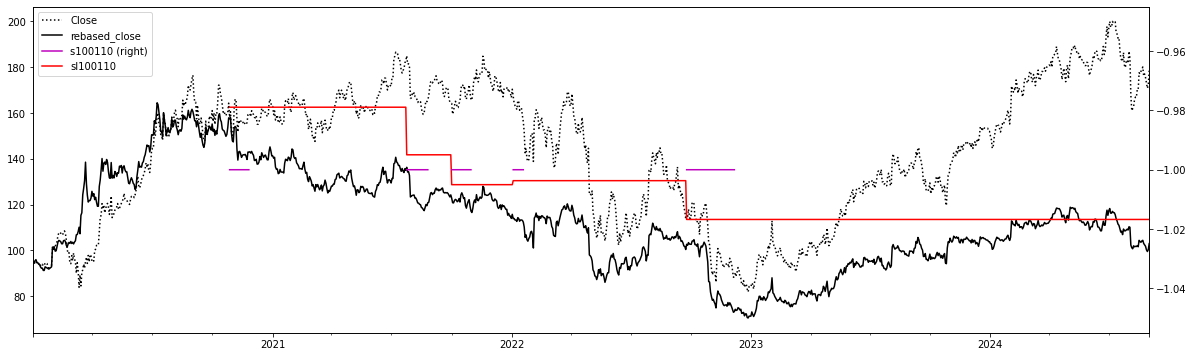

In [75]:
# Make a copy of high_score
data = high_score.copy()
data_cols = list(data.columns)
data[['Close', 'rebased_close', data_cols[7], data_cols[8]]].plot(secondary_y=[data_cols[7]],
                                                        style=['k:', 'k', 'm', 'r'], figsize=(20, 6))

# Print the columns
data.columns

In [76]:
# Make a copy of high_score
data = high_score.copy()
data_cols = list(data.columns)

In [77]:
# Declare variables

K = 1000000
constant_risk = 0.25 / 100
constant_weight = 3 / 100
signal = data[data_cols[7]]
signal[pd.isnull(signal)] = 0
position = data[data_cols[7]].shift(1)
position[pd.isnull(position)] = 0
sLoss = data[data_cols[8]]

<AxesSubplot:>

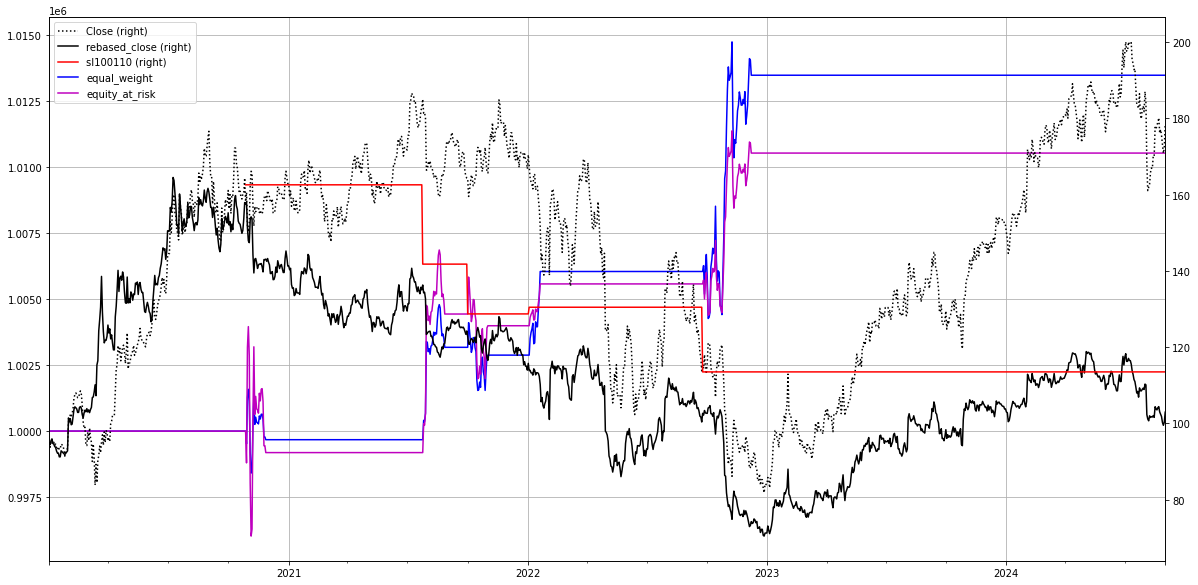

In [78]:
# Calculate the daily Close chg_1d
close_1d = data['Close'].diff().fillna(0)

# Define posSizer weight
data['eqty_risk'] = equity_at_risk(
    px_adj=data['rebased_close'], sLoss=sLoss, risk=constant_risk)

# Instantiation of equity curves
data['equity_at_risk'] = K
data['equal_weight'] = K

# Instantiation of round_lot for posSizer
eqty_risk_lot = 0
equal_weight_lot = 0

for i in range(len(data)):

    data['equity_at_risk'].iat[i] = (data['equity_at_risk'].iat[i-1] +
                                     close_1d.iat[i] * eqty_risk_lot * abs(position.iat[i]))

    data['equal_weight'].iat[i] = (data['equal_weight'].iat[i-1] +
                                   close_1d.iat[i] * equal_weight_lot * position.iat[i])

    if (signal.iat[i-1] == 0) & (signal.iat[i] != 0):
        eqty_risk_lot = round_lot(weight=data['eqty_risk'].iat[i],
                                  capital=data['equity_at_risk'].iat[i], fx_rate=1,
                                  price_local=data['Close'].iat[i], roundlot=100)

        equal_weight_lot = round_lot(weight=constant_weight,
                                     capital=data['equal_weight'].iat[i], fx_rate=1,
                                     price_local=data['Close'].iat[i], roundlot=100)

    else:
        pass

# print(equal_weight_lot,kelly_lot)

couleurs = ['k:', 'k', 'r', 'b', 'm', 'm-.', 'm:', 'g', 'c']
data[['Close', 'rebased_close', data_cols[8], 'equal_weight', 'equity_at_risk']].plot(
    secondary_y=['Close', 'rebased_close', data_cols[8]], style=couleurs, figsize=(20, 10), grid=True)

In [79]:
data.head()

,rebased_close,Close,r_return_1d,return_1d,r_regime_floorceiling,srebased_low,srebased_high,s100110,sl100110,score,trades,r_perf,csr,geo_GE,sqn,eqty_risk,equity_at_risk,equal_weight
2020-01-02,94.90,94.90,NaN,NaN,0.0,NaN,NaN,0.0,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000
2020-01-03,94.42,93.75,-0.005071,-0.012192,0.0,NaN,NaN,0.0,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000
2020-01-06,95.48,95.14,0.011164,0.014718,0.0,NaN,NaN,0.0,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000
2020-01-07,95.95,95.34,0.004910,0.002100,0.0,NaN,NaN,0.0,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000
2020-01-08,94.74,94.60,-0.012691,-0.007792,0.0,NaN,NaN,0.0,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000


In [80]:
short_book_rets = data[["equity_at_risk"]].pct_change().fillna(0)

## Calculate LongShort Strategy Returns

In [81]:
ls_rets = short_book_rets
ls_rets.rename(columns={'equity_at_risk': 'Short_Book'}, inplace=True)
ls_rets['Long_Book'] = hrp_returns
ls_rets.head()

,Short_Book,Long_Book
2020-01-02,0.0,0.014627
2020-01-03,0.0,-0.002277
2020-01-06,0.0,0.005943
2020-01-07,0.0,0.004077
2020-01-08,0.0,0.008331


In [82]:
ls_rets['Long_Short'] = ls_rets['Short_Book'].mul(0.3) + ls_rets['Long_Book'].mul(0.7)
ls_rets.head()

,Short_Book,Long_Book,Long_Short
2020-01-02,0.0,0.014627,0.010239
2020-01-03,0.0,-0.002277,-0.001594
2020-01-06,0.0,0.005943,0.004160
2020-01-07,0.0,0.004077,0.002854
2020-01-08,0.0,0.008331,0.005832


Start date,2020-01-02
End date,2024-08-30
Total months,57
,Backtest
Annual return,8.5%
Cumulative returns,48.5%
Annual volatility,17.9%
Sharpe ratio,0.55
Calmar ratio,0.33
Stability,0.16
Max drawdown,-26.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.05,2020-02-19,2020-03-18,2020-05-20,66
1,25.76,2021-11-12,2022-10-14,NaT,NaN
2,10.00,2021-02-09,2021-03-08,2021-04-26,55
3,7.60,2020-09-02,2020-09-24,2020-10-09,28
4,7.32,2021-04-26,2021-05-13,2021-06-24,44


Stress Events,mean,min,max
New Normal,0.04%,-8.16%,7.40%


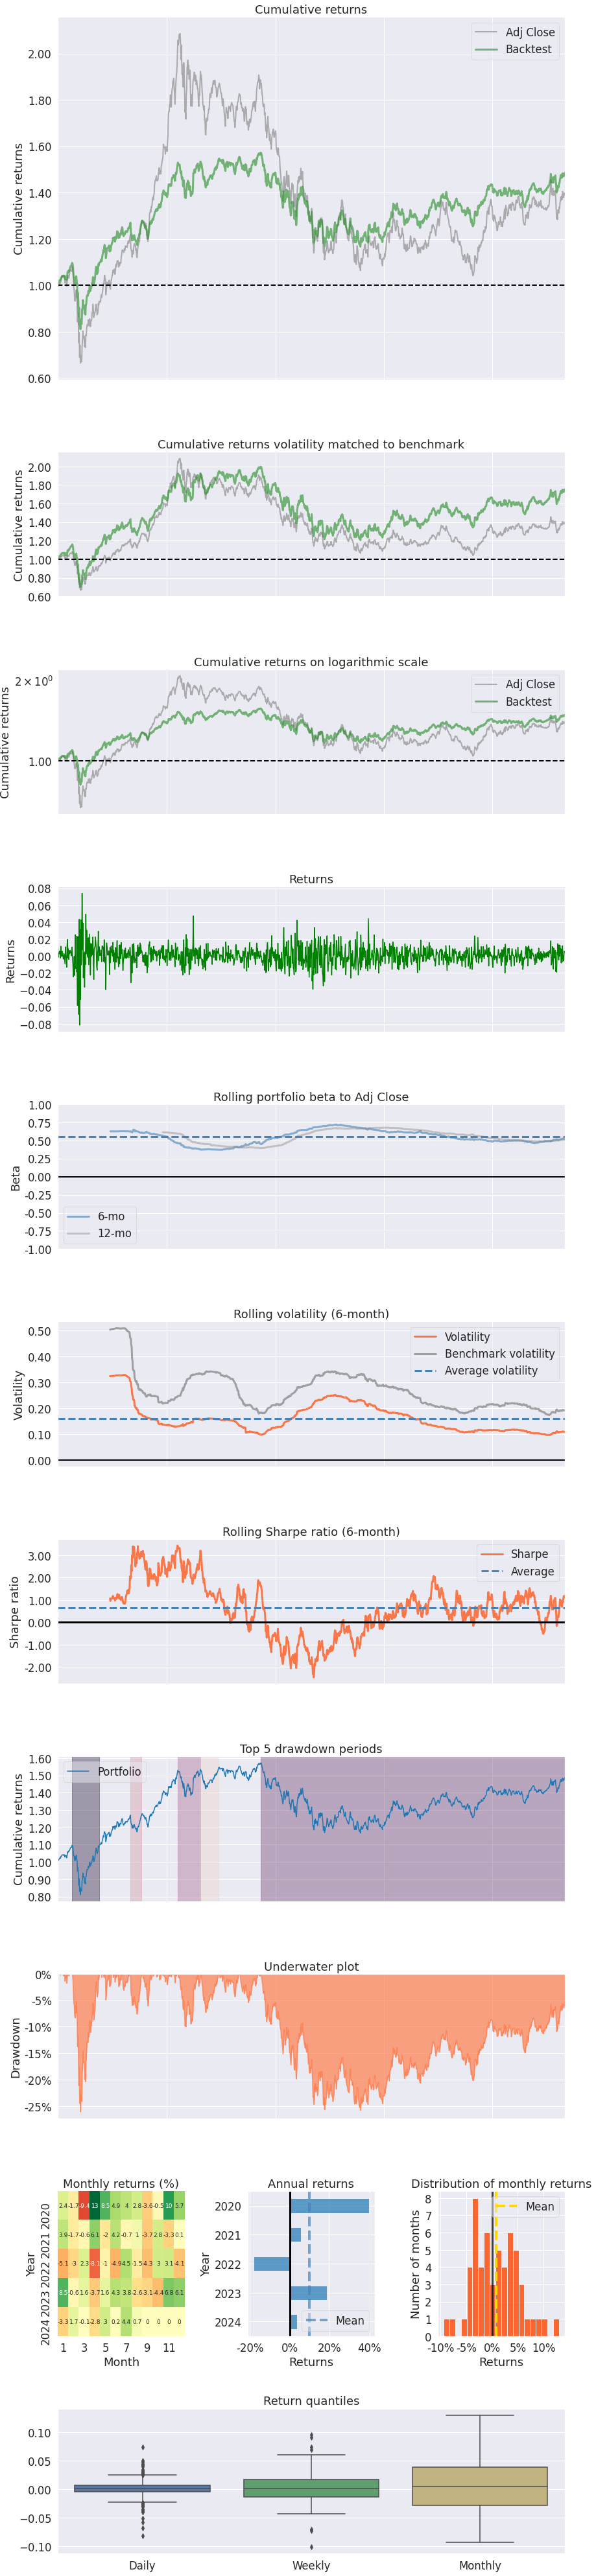

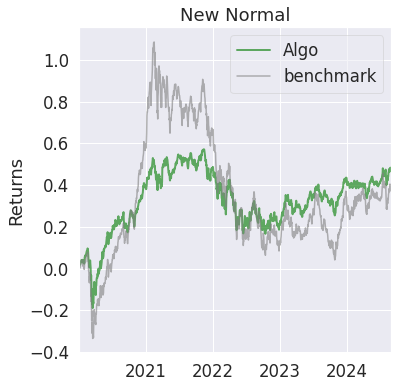

In [83]:
pf.create_full_tear_sheet(ls_rets['Long_Short'], 
                          benchmark_rets=komp_rets)